# Fine-Tuning Wav2Vec XLSR on Common Voice Hindi Dataset

We will fine-tune the **Wav2Vec XLSR** model on the **Common Voice Hindi** dataset. Wav2Vec XLSR is a powerful speech representation model that can be adapted for various speech recognition tasks. By fine-tuning it on a specific dataset, we aim to improve its performance on Hindi language speech recognition.

## Getting Started

In this section, we will:

1. **Login to Hugging Face**: Authenticate our session to access models and datasets.

2. **Download the Common Voice Hindi Dataset**: Acquire the dataset necessary for fine-tuning the Wav2Vec model.

### Step 1: Login to Hugging Face

To access Hugging Face resources, log in using your access token.

### Step 2: Download the Common Voice Hindi Dataset

Next, we will download the Common Voice Hindi dataset, which contains audio samples of spoken Hindi, essential for our fine-tuning process.

In [ ]:
!pip install datasets

In [ ]:
from huggingface_hub import login

# write your own secret key or token
login('your_token')

In [ ]:
# download dataset

from datasets import load_dataset, Audio

common_voice = {}

common_voice['train'] = load_dataset("mozilla-foundation/common_voice_17_0", "hi", split="train",trust_remote_code=True)
common_voice['test'] = load_dataset("mozilla-foundation/common_voice_17_0", "hi", split="test",trust_remote_code=True)


In [ ]:
print(common_voice)

## Preprocessing and Exploring the Dataset

In this section, we will preprocess the Common Voice Hindi dataset by removing unnecessary columns and exploring the transcripts. This step is crucial for preparing the data for training our Wav2Vec model.

### Steps:

1. **Remove Unnecessary Columns**: We will identify and drop any columns that are not needed for our speech recognition task. This will help streamline the dataset and reduce processing time.

2. **Explore Transcripts**: We will take a closer look at the transcripts in the dataset, examining their content, length, and any notable characteristics. This exploration will help us understand the data better and inform our training strategy.

### Step 1: Remove Unnecessary Columns

We'll start by examining the dataset structure and removing any columns that do not contribute to our model training.

### Step 2: Explore Transcripts

Next, we will explore the transcripts to gain insights into the language patterns, vocabulary, and overall dataset characteristics. This exploration will be valuable for evaluating the quality of our data and preparing for effective model training.

By completing these steps, we will have a cleaner dataset that is ready for further processing and model training.

In [ ]:
# remove unnecessary columns
common_voice['train'] = common_voice['train'].remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])
common_voice['test'] = common_voice['test'].remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])

In [ ]:
print(f"Columns in train: {common_voice['train'].column_names}")
print(f"Columns in test: {common_voice['test'].column_names}")

In [ ]:
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."

    # Randomly sample unique indices
    picks = random.sample(range(len(dataset)), num_examples)

    # Create a DataFrame with a new 'id' column and 'sentence' column
    df = pd.DataFrame({
        'id': picks,  # Use the sampled indices as IDs
        'sentence': [dataset[i]['sentence'] for i in picks]  # Extract sentences
    })

    # Display the DataFrame without the default index
    display(HTML(df.to_html(index=False)))

In [ ]:
show_random_elements(common_voice['train'], num_examples=10)

In [ ]:
show_random_elements(common_voice['test'], num_examples=10)

## Preprocessing Transcripts

In this section, we will focus on cleaning the transcripts from the Common Voice Hindi dataset. Specifically, we will remove special characters that are not relevant to the Hindi language. This preprocessing step is crucial for improving the quality of the data and enhancing the model's performance during training.

### Objectives:

1. **Identify Special Characters**: We'll define a set of special characters that need to be removed from the transcripts. This may include punctuation, digits, and any non-Hindi characters.

2. **Clean the Transcripts**: We will implement a function to process each transcript, removing the identified special characters and ensuring that the text is in a format suitable for training.

3. **Verify the Cleaned Data**: After cleaning, we'll take a look at a few samples to confirm that the preprocessing has been executed correctly.

By the end of this section, we will have a set of clean transcripts that are better suited for training the Wav2Vec model, thereby enhancing the overall performance of our speech recognition system.

In [ ]:
import re

# Define the characters to remove (only English letters and specific punctuation)
chars_to_remove_regex = r'[a-zA-Z!"#$%&\'()*+,./:;<=>?@[\\\]^_`{|}~]'

def remove_special_characters(batch):
    # Remove English alphabets and specified punctuation
    batch["sentence"] = re.sub(chars_to_remove_regex, '', batch["sentence"])
    return batch

In [ ]:
common_voice['train'] = common_voice['train'].map(remove_special_characters)
common_voice['test'] = common_voice['test'].map(remove_special_characters)

In [ ]:
show_random_elements(common_voice['train'], num_examples=10)

In [ ]:
show_random_elements(common_voice['test'], num_examples=10)

## Character Extraction and Vocabulary Creation

In this section, we will extract characters from the cleaned transcripts and create a vocabulary for the Hindi language. This vocabulary will be essential for training our Wav2Vec model, as it defines the set of symbols the model will recognize during speech recognition tasks.

### Objectives:

1. **Extract Unique Characters**: We will analyze the cleaned transcripts to identify all unique characters used in the Hindi language. This will include vowels, consonants, and any relevant symbols.

2. **Create Vocabulary**: Based on the unique characters extracted, we will construct a vocabulary list. This vocabulary will serve as the foundation for our model, enabling it to map audio features to corresponding textual representations.

3. **Save Vocabulary for Future Use**: Finally, we will save the created vocabulary to a file for easy access during model training and evaluation.

### Importance:

Having a well-defined vocabulary is crucial for effective speech recognition. It not only helps in accurately mapping audio to text but also ensures that the model understands the structure and nuances of the Hindi language.

In [ ]:
def extract_all_chars(batch):
  all_text = " ".join(batch["sentence"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [ ]:
vocab_train = common_voice['train'].map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice['train'].column_names)
vocab_test = common_voice['test'].map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice['test'].column_names)

In [ ]:
vocab_list = list(set(vocab_train["vocab"][0]) | set(vocab_test["vocab"][0]))

In [ ]:
vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}
vocab_dict


In [ ]:
# make seperate token for space ' '
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [ ]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

In [ ]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

## Create Wav2Vec2CTCTokenizer

In this section, we will create a **Wav2Vec2CTCTokenizer** for our speech recognition model. This tokenizer is essential for converting text into token IDs that the model can understand, enabling it to process and recognize speech effectively.

### Objectives:

1. **Understand Tokenization**: Tokenization is the process of converting text into a format suitable for the model. For speech recognition, this involves mapping characters in the vocabulary to unique integer IDs.

2. **Create the Tokenizer**: We will instantiate the Wav2Vec2CTCTokenizer using our previously defined vocabulary. This tokenizer will facilitate the conversion of transcripts into token IDs during training and inference.

3. **Test the Tokenizer**: After creating the tokenizer, we will run a few examples through it to ensure it is functioning correctly and producing the expected output.

### Importance:

Having a well-defined tokenizer is crucial for the training and evaluation of the model. It allows the model to interpret and generate text accurately based on the audio input. A tokenizer that aligns closely with the vocabulary used in the training data will enhance the model's performance in real-world applications.

In [ ]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("./", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

In [ ]:
from huggingface_hub import login

# write your own secret key or token
login('your_token')

In [ ]:
repo_name = "wav2vec2-large-xls-r-300m-hindi-colab-total"

In [ ]:
tokenizer.push_to_hub(repo_name)

## Create Wav2Vec2FeatureExtractor & Wav2Vec2Processor

In this section, we will create a **Wav2Vec2FeatureExtractor** for our Wav2Vec model. The feature extractor is responsible for processing audio input and converting it into a suitable format for the model to work with. This step is essential for ensuring that the audio data is correctly preprocessed before being fed into the model.

### Objectives:

1. **Understand Feature Extraction**: Feature extraction involves transforming raw audio waveforms into a format that the model can understand. This typically includes steps like resampling, normalization, and potentially applying feature extraction techniques.

2. **Instantiate the Feature Extractor**: We will create a Wav2Vec2FeatureExtractor using the appropriate parameters. This will configure the extractor to handle the audio inputs for our specific task.

3. **Test the Feature Extractor**: After creating the feature extractor, we will run some sample audio data through it to verify that it produces the expected output.

### Importance:

A well-defined feature extractor is critical for the model's performance. It ensures that the input audio is in the right format and quality, which can significantly impact the model's ability to accurately recognize speech. The feature extractor will help in normalizing the audio data, making it consistent and ready for further processing.

In [ ]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)

In [ ]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

## Preprocess Audio Data

In this section, we will preprocess the audio data to prepare it for training our Wav2Vec model. Proper audio preprocessing is essential for effective speech recognition.

### Objectives:

1. **Load Audio Files**: Retrieve audio samples from the Common Voice Hindi dataset.
2. **Apply Feature Extractor**: Use the Wav2Vec2FeatureExtractor to transform raw audio into feature representations.
3. **Organize Data**: Structure the processed audio and corresponding transcripts for model training.

In [ ]:
common_voice['train'][0]["path"]

In [ ]:
common_voice['train'][0]['audio']

In [ ]:
# Downsample sampling rate
common_voice['train'] = common_voice['train'].cast_column("audio", Audio(sampling_rate=16_000))
common_voice['test'] = common_voice['test'].cast_column("audio", Audio(sampling_rate=16_000))

In [ ]:
# check audio
common_voice['train'][0]['audio'] # sampling rate 16kHz

## Explore Audio Files

In this section, we will explore the audio files from the Common Voice Hindi dataset. This exploration is crucial for understanding the quality and characteristics of the audio data we will be working with during model training.

### Objectives:

1. **Inspect Audio Samples**: We will listen to a selection of audio samples to evaluate their clarity, volume, and overall quality. This will help us identify any potential issues that may affect model performance.

2. **Analyze Audio Properties**: We will examine key properties of the audio files, such as sample rate, duration, and format. Understanding these characteristics will inform our preprocessing steps and ensure consistency across the dataset.

3. **Visualize Audio Waveforms**: By plotting waveforms of selected audio samples, we can visually assess variations in amplitude and frequency. This visualization will aid in identifying patterns and anomalies in the audio data.

### Importance:

Exploring the audio files is vital for ensuring that the dataset is suitable for training our Wav2Vec model. By understanding the quality and characteristics of the audio, we can make informed decisions about preprocessing and any necessary enhancements.


In [ ]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(common_voice['train'])-1)

print(common_voice['train'][rand_int]["sentence"])
ipd.Audio(data=common_voice['train'][rand_int]["audio"]["array"], autoplay=True, rate=16000)

In [ ]:
rand_int = random.randint(0, len(common_voice['train'])-1)

print("Target text:", common_voice['train'][rand_int]["sentence"])
print("Input array shape:", common_voice['train'][rand_int]["audio"]["array"].shape)
print("Sampling rate:", common_voice['train'][rand_int]["audio"]["sampling_rate"])

## Visualize Audios

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Access audio data and sampling rate
audio_data = common_voice['train'][0]['audio']["array"]
sampling_rate = common_voice['train'][0]['audio']["sampling_rate"]  # Extract the sampling rate value

# Create a spectrogram
D = librosa.stft(audio_data)  # Short-time Fourier transform
S_db = librosa.amplitude_to_db(abs(D), ref=np.max)  # Convert to decibels

# Plotting the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sampling_rate, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()


In [ ]:
# Compute the chromagram
chromagram = librosa.feature.chroma_stft(y=audio_data, sr=sampling_rate)

# Plotting the chromagram
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, sr=sampling_rate, x_axis='time', y_axis='chroma', cmap='viridis')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()
plt.show()


In [ ]:
zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio_data)

plt.figure(figsize=(10, 4))
plt.plot(zero_crossing_rate[0])
plt.title('Zero-Crossing Rate')
plt.xlabel('Frames')
plt.ylabel('Rate')
plt.grid()
plt.show()

In [ ]:
spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sampling_rate)

plt.figure(figsize=(10, 4))
plt.semilogy(spectral_centroid[0], label='Spectral Centroid', color='r')
plt.title('Spectral Centroid')
plt.ylabel('Hz')
plt.xticks([])
plt.xlim([0, spectral_centroid.shape[-1]])
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
# Create a Log-Mel spectrogram
S_mel = librosa.feature.melspectrogram(y=audio_data, sr=sampling_rate, n_mels=128, fmax=8000)
S_log_mel_db = librosa.amplitude_to_db(S_mel, ref=np.max)

# Plotting the Log-Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_log_mel_db, sr=sampling_rate, x_axis='time', y_axis='mel', fmax=8000, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram')
plt.tight_layout()
plt.show()

In [ ]:
# Compute the CQT
C = librosa.cqt(audio_data, sr=sampling_rate)
C_db = librosa.amplitude_to_db(np.abs(C), ref=np.max)

# Plotting the CQT spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(C_db, sr=sampling_rate, x_axis='time', y_axis='cqt_hz', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q Transform (CQT) Spectrogram')
plt.tight_layout()
plt.show()

In [ ]:
# Create an STFT spectrogram with custom parameters
D = librosa.stft(audio_data, n_fft=2048, hop_length=512)  # Adjust n_fft and hop_length as needed
S_db_stft = librosa.amplitude_to_db(abs(D), ref=np.max)

# Plotting the STFT spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db_stft, sr=sampling_rate, x_axis='time', y_axis='linear', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Short-Time Fourier Transform (STFT) Spectrogram')
plt.tight_layout()
plt.show()

In [ ]:
# Compute the spectral contrast
spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sampling_rate)

# Plotting the spectral contrast
plt.figure(figsize=(10, 4))
plt.semilogy(spectral_contrast[0], label='Spectral Contrast', color='r')
plt.title('Spectral Contrast')
plt.ylabel('Spectral Contrast')
plt.xticks([])
plt.xlim([0, spectral_contrast.shape[-1]])
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
# Compute MFCCs
mfccs = librosa.feature.mfcc(y=audio_data, sr=sampling_rate, n_mfcc=13)

# Plotting the MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sampling_rate, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Compute the Short-Time Fourier Transform (STFT)
D = librosa.stft(audio_data)

# Get the pitch tracking
pitches, magnitudes = librosa.piptrack(y=audio_data, sr=sampling_rate)

# Select the maximum pitch for each time frame
pitch_values = np.array([p[np.argmax(m)] if np.max(m) > 0 else 0 for p, m in zip(pitches.T, magnitudes.T)])

# Plotting the pitch over time
plt.figure(figsize=(10, 4))
plt.plot(pitch_values, label='Pitch', color='r')
plt.title('Pitch Tracking')
plt.xlabel('Frames')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Compute spectral flatness
spectral_flatness = librosa.feature.spectral_flatness(y=audio_data)

# Plotting spectral flatness
plt.figure(figsize=(10, 4))
plt.semilogy(spectral_flatness[0], label='Spectral Flatness', color='b')
plt.title('Spectral Flatness')
plt.ylabel('Spectral Flatness')
plt.xlabel('Frames')
plt.xlim([0, spectral_flatness.shape[-1]])
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Compute the spectrogram for a specific segment
D = librosa.stft(audio_data)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Plotting the spectrogram with highlighted formants
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sampling_rate, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram with Formants')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(audio_data, label='Audio Waveform')
plt.title('Audio Waveform')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Define a threshold to distinguish between signal and noise
threshold = 0.05  # Adjust based on your audio data

# Compute the noise level
noise = audio_data[audio_data < threshold]
signal = audio_data[audio_data >= threshold]

noise_level = np.mean(np.abs(noise)) if len(noise) > 0 else 0
signal_level = np.mean(np.abs(signal)) if len(signal) > 0 else 0

nsr = noise_level / signal_level if signal_level > 0 else float('inf')
print(f"Noise-to-Signal Ratio: {nsr:.4f}")

In [ ]:
# Compute the FFT
fft_values = np.fft.fft(audio_data)
frequencies = np.fft.fftfreq(len(fft_values), 1/sampling_rate)

# Plotting the frequency components
plt.figure(figsize=(10, 4))
plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_values)[:len(fft_values)//2])
plt.title('Frequency Domain')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 8000)  # Limit x-axis to relevant frequencies
plt.grid()
plt.show()

In [ ]:
# Compute spectral flatness
spectral_flatness = librosa.feature.spectral_flatness(y=audio_data)

# Plotting spectral flatness
plt.figure(figsize=(10, 4))
plt.semilogy(spectral_flatness[0], label='Spectral Flatness', color='b')
plt.title('Spectral Flatness')
plt.ylabel('Spectral Flatness')
plt.xlabel('Frames')
plt.xlim([0, spectral_flatness.shape[-1]])
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Simulated example for spatial audio
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(2 * np.pi * (X**2 + Y**2))  # Example data

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_title('3D Soundfield Visualization')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Amplitude')
plt.show()

## Prepare Dataset

In [ ]:
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched"
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["sentence"]).input_ids
    return batch

In [ ]:
common_voice['train'] = common_voice['train'].map(prepare_dataset, remove_columns=common_voice['train'].column_names)
common_voice['test'] = common_voice['test'].map(prepare_dataset, remove_columns=common_voice['test'].column_names)

## Training Pipeline Setup

We are now ready to set up the training pipeline using Hugging Face's Trainer for fine-tuning the Wav2Vec model. The steps involved include:

1. **Define a Data Collator**: Given the large input sizes of XLS-R, we'll implement a data collator that dynamically pads training batches to the length of the longest sample in each batch, rather than the overall longest sample. This is essential for efficient training.

2. **Evaluation Metric**: We'll establish a `compute_metrics` function to evaluate the model using the word error rate (WER) during training.

3. **Load Pretrained Checkpoint**: A pretrained checkpoint will be loaded and configured properly for our training task.

4. **Training Configuration**: Define the training parameters, including learning rate, batch size, and number of epochs.

5. **Model Evaluation**: After fine-tuning the model, we will evaluate it on the test dataset to confirm its accuracy in transcribing speech.

### Data Collator Setup
We'll begin by implementing the data collator. This specialized collator treats `input_values` and `labels` separately, applying distinct padding methods for each. Labels will use a padding token of `-100` to exclude those tokens from loss calculations.

This structured approach will ensure an efficient and effective training process for the Wav2Vec model.

In [ ]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [ ]:
!pip install evaluate
!pip install jiwer

In [ ]:
from evaluate import load

wer_metric = load("wer")

In [ ]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [ ]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-xls-r-300m",
    attention_dropout=0.0,
    hidden_dropout=0.0,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.0,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer),
)

In [ ]:
model.freeze_feature_extractor()

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir=repo_name,
  # run_name="finetuned_wav2vec_hindi",
  group_by_length=True,
  report_to="none",
  per_device_train_batch_size=16,
  gradient_accumulation_steps=2,
  eval_strategy="steps",
  num_train_epochs=30,
  gradient_checkpointing=True,
  fp16=True,
  save_steps=400,
  eval_steps=400,
  logging_steps=400,
  learning_rate=3e-4,
  warmup_steps=500,
  save_total_limit=2,
  push_to_hub=False,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=common_voice['train'],
    eval_dataset=common_voice['test'],
    tokenizer=processor.feature_extractor,
)

In [ ]:
trainer.train()

In [ ]:
trainer.push_to_hub()

## Evaluation of model

In [ ]:
# if loading model from pretrained checkpoints
model = Wav2Vec2ForCTC.from_pretrained('Athrensis/wav2vec2-large-xls-r-300m-hindi-colab-total').to("cuda")
processor = Wav2Vec2Processor.from_pretrained('Athrensis/wav2vec2-large-xls-r-300m-hindi-colab-total', use_auth_token='your_token')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

In [ ]:
input_dict = processor(common_voice['test'][5]["input_values"],sampling_rate=16000, return_tensors="pt", padding=True)

logits = model(input_dict.input_values.to(device)).logits

pred_ids = torch.argmax(logits, dim=-1)[0]

In [ ]:
# get original dataset back
common_voice_test_transcription = load_dataset("mozilla-foundation/common_voice_17_0", "hi", split="test")

In [ ]:
print("Prediction:")
print(processor.decode(pred_ids))

print("\nReference:")
print(common_voice_test_transcription[5]["sentence"].lower())

## WER graph

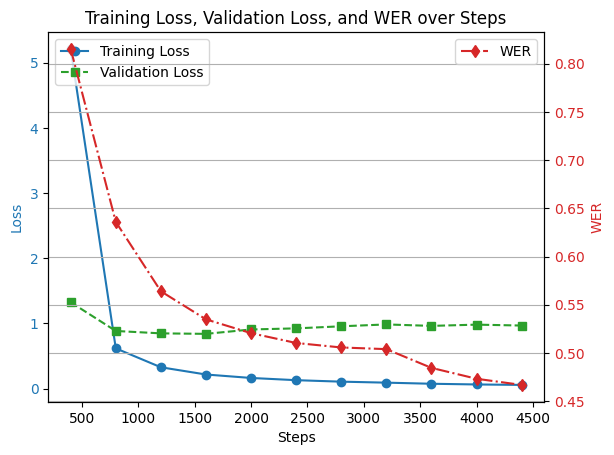

In [4]:
import matplotlib.pyplot as plt

# Data
steps = [400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000, 4400]
training_loss = [5.2118, 0.6184, 0.3282, 0.2173, 0.1643, 0.1302, 0.1076, 0.0923, 0.0754, 0.0646, 0.0575]
validation_loss = [1.325244, 0.885186, 0.848446, 0.840873, 0.908178, 0.925040, 0.956912, 0.985446, 0.963144, 0.982244, 0.968380]
wer = [0.815215, 0.635927, 0.563966, 0.534866, 0.520566, 0.510379, 0.505728, 0.503998, 0.484585, 0.473284, 0.466902]

# Create plot
fig, ax1 = plt.subplots()

# Plot Training Loss and Validation Loss
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(steps, training_loss, marker='o', linestyle='-', color='tab:blue', label='Training Loss')
ax1.plot(steps, validation_loss, marker='s', linestyle='--', color='tab:green', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Create a secondary y-axis for WER
ax2 = ax1.twinx()
ax2.set_ylabel('WER', color='tab:red')
ax2.plot(steps, wer, marker='d', linestyle='-.', color='tab:red', label='WER')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

# Title and Grid
plt.title('Training Loss, Validation Loss, and WER over Steps')
plt.grid()

# Show plot
plt.show()